# corpus exploring

In [30]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from nltk import word_tokenize
import numpy as np
import pandas as pd
import re
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from stop_words import get_stop_words
import seaborn as sns


from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, Normalizer

from yellowbrick.text import UMAPVisualizer
from yellowbrick.style import set_palette

from utils import add_epoch_division, linkage_matrix, merge_corpus_poets, plot_dendrogram, remove_noise_poet, text_cleaning

In [31]:
corpus = text_cleaning(pd.read_csv("../corpora/german_poems.csv"))

In [32]:
LOWERCASE = True
MAX_FEATURES = 10000
STOP_WORDS = get_stop_words("de")

In [33]:
with open("epochs.json") as f:
    epochs = json.loads(f.read())

epochs = epochs["amann"]
epoch_exceptions = ["Sturm_Drang"]
corpus = add_epoch_division(corpus, epochs, epoch_exceptions=epoch_exceptions)
corpus = merge_corpus_poets(corpus)
corpus = corpus[corpus.epoch != ""]

In [34]:
text = corpus["poem"].values
labels = LabelEncoder().fit_transform(corpus["epoch"].values)
unique_epochs = list(np.unique(corpus["epoch"]))


vectorizer = TfidfVectorizer(max_df=0.5,
                             lowercase=LOWERCASE,
                             max_features=MAX_FEATURES,
                             stop_words=STOP_WORDS)
vector = vectorizer.fit_transform(text)

In [35]:
#todo: literatur
epochs_ruffig = {"Barock": (1600, 1720),
                  "Frühaufklärung": (1700, 1755),
                  "Aufklärung": (1755, 1810),
                  "Klassik_Romantik": (1786, 1832),
                  "Biedermeier": (1815, 1848),
                  "Realismus": (1848, 1900),
                  "Moderne": (1880, 1918),
                  "Weimarer Republik": (1918, 1933)}

## Histogramme

### Verteilung der Gedichte nach Erscheinungsjahren

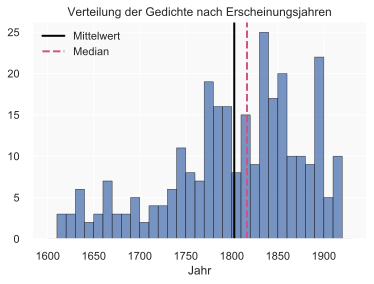

In [36]:
sns.distplot(corpus.year, 
             kde=False, 
             rug=False, 
             bins=range(1600, 1933, 10),  
             hist_kws=dict(edgecolor="black", linewidth=0.5, alpha=0.75),
             axlabel="Jahr")
plt.axvline(corpus.year.mean(), 0, 1, 
            linestyle="-",
            linewidth=2.0,
            color="black",
            label="Mittelwert")
plt.axvline(corpus.year.median(), 0, 1, 
            linestyle="--",
            linewidth=2.0,
            color="#d45087",
            label="Median")
plt.legend()
sns.set(rc={'axes.facecolor':'#f9f9f9', 'figure.facecolor':'#ffffff'})
plt.title("Verteilung der Gedichte nach Erscheinungsjahren")
#plt.savefig("img/general/poems_distribution_years)", dpi=300)
plt.show()

### Verteilung der Gedichte nach Anzahl der Tokens (= Länge der Gedichte)

In [37]:
corpus["poemlength"] = corpus.poem.apply(lambda x: len(word_tokenize(x)))

In [20]:
corpus.head(2)

,id,poet,poem,year,epoch,poemlength
0,0,"Abschatz, Hans Aßmann von",Was bleibt von Reichen unbekannt? Hält gleich ...,1678,Barock,75319
1,1,"Ahlefeld, Charlotte von","Nimm hin dies Bild, das auch in weite Ferne Di...",1815,Klassik,11967


In [38]:
corpus.shape

(288, 6)

In [39]:
corpus = corpus[corpus.poemlength >= 1000]

In [48]:
corpus.to_csv("../corpora/amann_poems.csv")

In [50]:
pd.read_csv("../corpora/amann_poems.csv", index_col=0)

,id,poet,poem,year,epoch,poemlength
0,0,"Abschatz, Hans Aßmann von",Was bleibt von Reichen unbekannt? Hält gleich ...,1678,Barock,75319
1,1,"Ahlefeld, Charlotte von","Nimm hin dies Bild, das auch in weite Ferne Di...",1815,Klassik,11967
2,2,Angelus Silesius,Der Liebe Mittelpunkt ist Gott und auch ihr Kr...,1650,Barock,42172
3,3,"Arndt, Ernst Moritz",Wo kommst du her in dem roten Kleid Und färbst...,1814,Klassik,66023
4,4,"Arnim, Ludwig Achim von","Fahre fort mit Liebesschlägen, Süßer Jesu, lie...",1806,Klassik,227812
...,...,...,...,...,...,...
316,316,"Zachariae, Justus Friedrich Wilhelm","Singe, scherzende Muse, die großen heroischen ...",1759,Aufklärung,60982
317,317,"Zesen, Philipp von",Echo zeige mier mein Leben/ E. ja dier eben. W...,1644,Barock,26294
318,318,"Ziegler, Christiana Mariana von","Die Dicht- und Redner Kunst liebt, was der Wit...",1727,Aufklärung,93650
319,319,"Zinzendorf, Nikolaus Ludwig von","Du fragst: Du rechtes Witwen-Herz, Ich sage vo...",1732,Aufklärung,109074


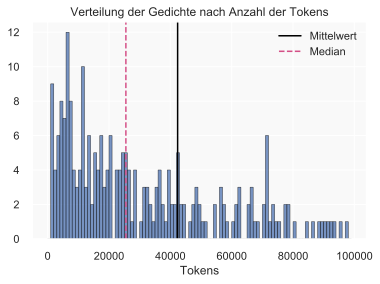

In [52]:
sns.distplot(corpus.poemlength, 
             kde=False, 
             rug=False, 
             bins=range(1, 100000, 1000), 
             hist_kws=dict(edgecolor="black", linewidth=0.5, alpha=0.75),
             axlabel="Tokens")
plt.axvline(corpus.poemlength.mean(), 0, 1, 
            linestyle="-",
            color="black",
            label="Mittelwert")
plt.axvline(corpus.poemlength.median(), 0, 1, 
            linestyle="--",
            color="#d45087",
            label="Median")
plt.legend()
sns.set(rc={'axes.facecolor':'#f9f9f9', 'figure.facecolor':'#ffffff'})
plt.title("Verteilung der Gedichte nach Anzahl der Tokens")
#plt.savefig("../results/figures/poems_mp_distribution.png", dpi=300)
plt.show()

## Verteilung der Anzahl der geschriebenen Gedichte jedes Dichter 

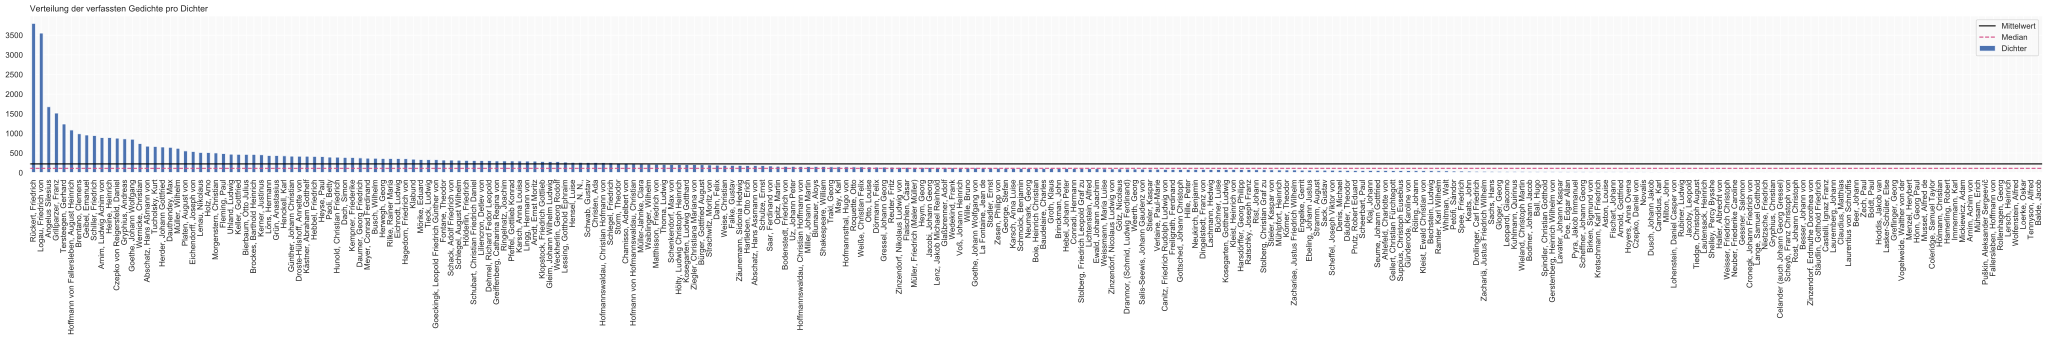

In [26]:
poems.poet.value_counts().plot(kind="bar",
                               figsize=(50, 4),
                               label="Dichter")
plt.axhline(poems.poet.value_counts().mean(), 0, 1, 
            linestyle="-",
            color="black",
            label="Mittelwert")
plt.axhline(poems.poet.value_counts().median(), 0, 1, 
            linestyle="--",
            color="#d45087",
            label="Median")
sns.set(rc={'axes.facecolor':'#f9f9f9', 'figure.facecolor':'#ffffff'})
plt.legend()
plt.title("Verteilung der verfassten Gedichte pro Dichter", loc="left")
plt.savefig("img/general/poet_distribution", dpi=300)
plt.show()